# Описание проекта
Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки.
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.
**Нужно спрогнозировать сразу две величины:**
- эффективность обогащения чернового концентрата rougher.output.recovery;
- эффективность обогащения финального концентрата final.output.recovery.

**Метрика качества:**
Итоговая метрика складывается из двух величин:
**Итоговое sMAPE = 25% * sMAPE(rougher) + 75% * sMAPE(final)**

## Постановка задачи

1. Подготовьте данные

2. Проанализируйте данные

3. Постройте модель



### [Шаг 1. Знакомство с данными, их изучение и предобработка](#section1)
1.1. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака `rougher.output.recovery`. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.
1.2. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
1.3. Проведите предобработку данных.

### [Шаг 2. Анализ данных:](#section2)
2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.
2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.
2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

### [Шаг 3. Построение модели и её оценка:](#section3)
3.1. Напишите функцию для вычисления итоговой sMAPE.
3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

### [Шаг 4. Общий вывод](#section4)


### Описание данных
Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.

**Технологический процесс**
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate **— ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

**Параметры этапов**
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

**Наименование признаков**
Наименование признаков должно быть такое: `[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока `[тип_параметра]`:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

# Решение задачи
## Шаг 1. Знакомство с данными, их изучение и предобработка <a class="anchor" id="section1"></a>

Импортируем необходимые библиотеки для дальнейшей работы.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings

warnings.filterwarnings('ignore')

In [2]:
# Зафиксируем важные значения
RANDOM_VAL = np.random.RandomState(42)
TARGETS = ['rougher.output.recovery', 'final.output.recovery']

METALS = ['au', 'ag', 'pb']

CONCENTRATE_METRICS = [
    'rougher.input.feed',
    'rougher.output.concentrate',
    'primary_cleaner.output.concentrate',
    'final.output.concentrate',
]

In [3]:
gold_train_data = pd.read_csv('gold_recovery_train_new.csv')
gold_test_data = pd.read_csv('gold_recovery_test_new.csv')
gold_full_data = pd.read_csv('gold_recovery_full_new.csv')

In [4]:
# Функция оценки пропусков в таблице
def pass_value_barh(data):
    try:
        (
            (data.isna().mean() * 100)
            .to_frame()
            .rename(columns={0: 'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind='barh', figsize=(20, 10), legend=False, fontsize=10)
            .set_title('Пропущенные значения, %' + "\n", fontsize=22)
        )
        print('Всего значений в таблице {0}, из них пропущено от {1} до {2} значений, доля пропущенных '
              'равна от {3:.2%} до {4:.2%} в {5} столбцах.'.format(len(data),
                                                                   min(i for i in data.isna().sum() if i > 0),
                                                                   max(data.isna().sum()),
                                                                   min(i for i in data.isna().sum() if i > 0) / len(
                                                                       data),
                                                                   max(data.isna().sum()) / len(data),
                                                                   (data.isna().sum(axis=0) > 0).sum()
                                                                   ))
    except:
        print('пропусков не осталось :) ')

In [5]:
# Функция изучения данных в таблице
def research_info(data):
    rows_count, columns_count = data.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    print('Дубликатов: {}'.format(data.duplicated().sum()))
    display(data.sample(n=5))
    pass_value_barh(data)

Количество стобцов: 87
Количество строк: 14149
Дубликатов: 0


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
9005,2017-07-29 17:59:59,3.667456,11.659235,7.574779,44.737404,59.301350,7.997429,3.824737,11.698831,2.970416,...,13.009034,-503.607595,10.023995,-400.207144,13.013730,-503.547010,10.031861,-500.272394,15.009617,-501.170086
11180,2018-03-23 07:59:59,4.681696,11.959862,7.182401,44.875709,74.000102,9.180696,2.199838,9.247985,2.204542,...,22.966384,-499.719001,15.070432,-499.419759,29.998428,-499.750451,14.976926,-500.069054,12.967281,-499.374022
6054,2017-03-08 09:59:59,6.891927,9.820019,7.708458,43.198202,63.119177,8.754875,3.331405,7.548296,3.714926,...,24.975591,-399.865127,22.940944,-399.649931,22.759373,-450.124185,19.984738,-449.856795,24.980833,-499.893207
4147,2016-08-07 16:59:59,4.957130,12.635470,12.746676,42.698941,46.110664,7.390801,2.506346,10.129834,3.658015,...,20.014471,-399.538161,9.927296,-400.496707,8.468734,-399.394599,5.093794,-400.229421,23.001410,-500.001771
12414,2018-05-23 14:59:59,4.573892,10.293622,6.999051,44.817731,66.580167,8.774376,2.357834,9.433245,2.789549,...,29.991220,-499.178579,20.067141,-500.326205,18.000531,-499.943382,13.983684,-499.920484,14.002842,-499.461109


Всего значений в таблице 14149, из них пропущено от 1 до 1605 значений, доля пропущенных равна от 0.01% до 11.34% в 62 столбцах.


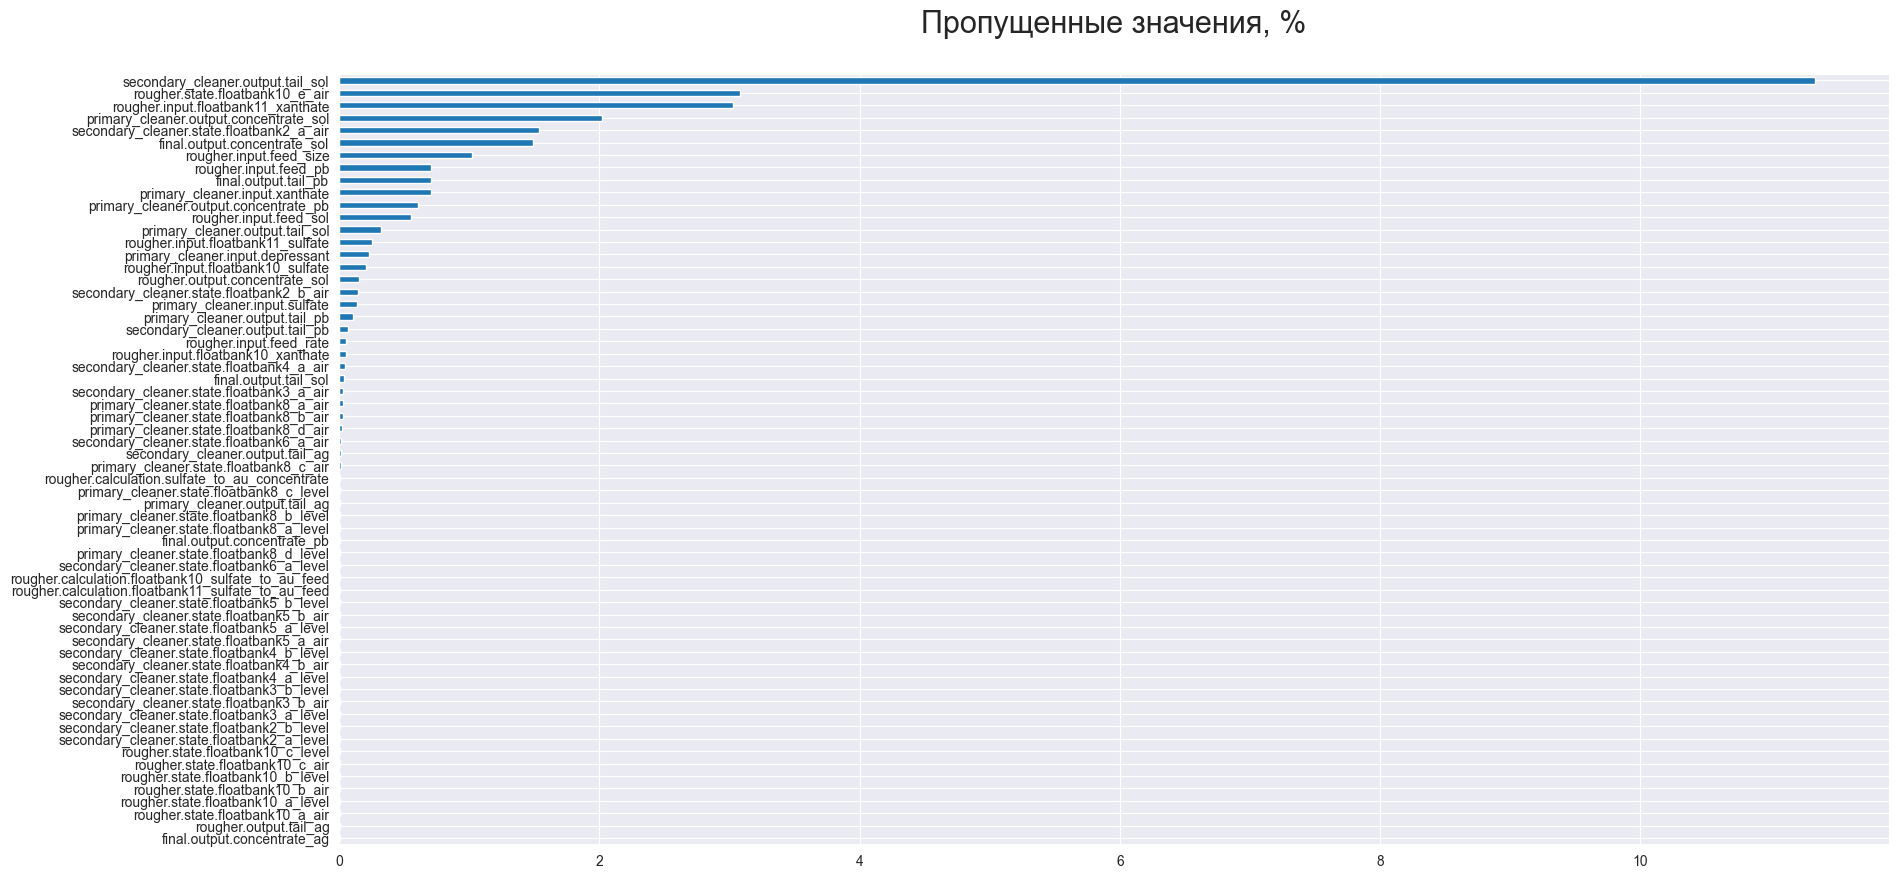

In [6]:
research_info(gold_train_data)

Количество стобцов: 87
Количество строк: 19439
Дубликатов: 0


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
14676,2017-12-13 21:59:59,4.447731,9.478523,9.773904,47.927366,63.979709,10.064234,1.607552,14.200321,3.970763,...,19.994179,-498.159839,15.100562,-113.908796,10.976250,-499.162730,8.004093,-499.834891,12.021626,-499.291076
4041,2016-08-03 02:59:59,4.831039,10.881252,7.886165,43.034422,51.231379,8.433413,2.434133,7.420837,3.273918,...,20.068604,-400.080056,9.924416,-399.096720,9.987047,-401.277699,5.000898,-399.869878,23.005206,-499.679896
4917,2016-09-11 04:59:59,5.781889,8.591869,10.598105,46.311221,55.366999,10.875304,3.319667,8.474820,4.825613,...,7.972638,-497.461052,4.932692,-498.267222,7.930635,-494.358006,3.022961,-498.096612,20.006412,-599.114495
4955,2016-09-13 12:59:59,7.054076,8.384440,10.676608,43.737732,66.157823,10.649445,2.893349,10.185031,4.001517,...,7.943964,-499.790416,4.900880,-496.510470,8.029992,-498.904598,3.060894,-500.509781,19.950047,-500.207561
15731,2018-02-17 08:59:59,6.357193,9.220314,8.495861,44.046890,85.346582,10.147783,0.762797,13.971163,1.544984,...,20.001801,-498.949823,15.008260,-499.563844,11.012457,-499.347360,8.970505,-500.137562,10.983370,-497.720570


Всего значений в таблице 19439, из них пропущено от 1 до 1748 значений, доля пропущенных равна от 0.01% до 8.99% в 63 столбцах.


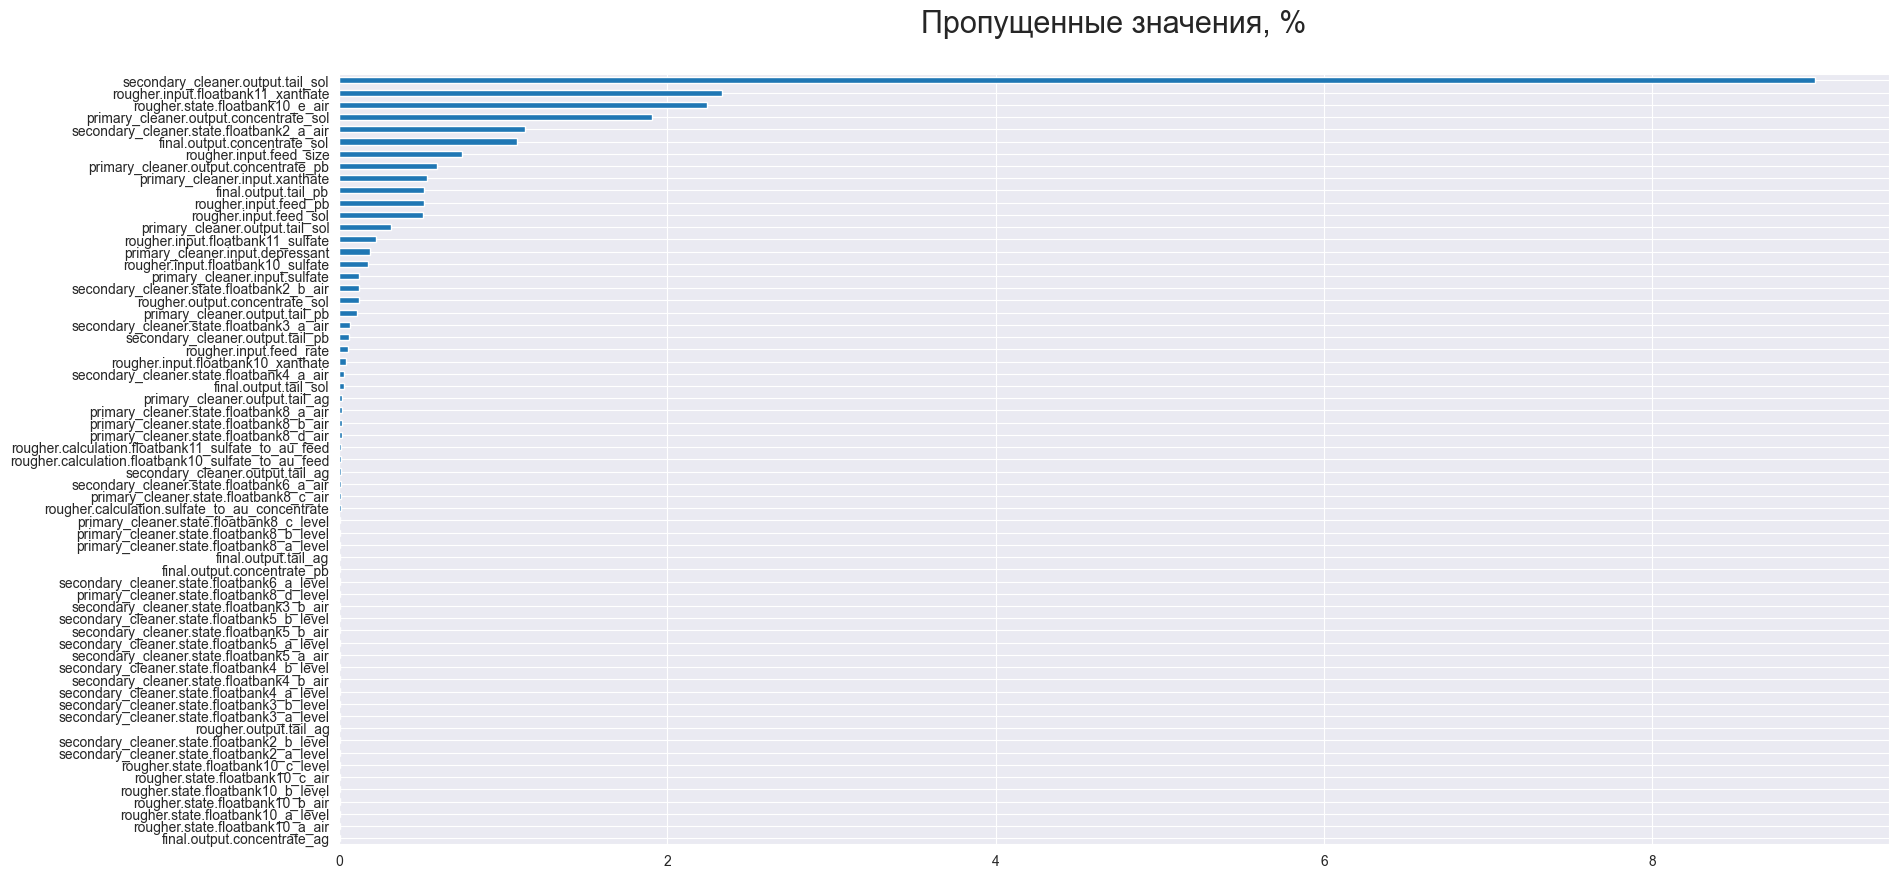

In [7]:
research_info(gold_full_data)

Количество стобцов: 53
Количество строк: 5290
Дубликатов: 0


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
247,2016-09-12 10:59:59,175.079520,5.051747,7.830000,0.792648,1298.038790,-499.177501,1299.411920,-500.698584,1296.474748,...,8.009979,-499.834253,5.078713,-499.772249,7.942081,-499.781749,2.979415,-499.776254,19.929365,-500.602266
3613,2017-10-18 17:59:59,241.750961,6.988769,6.320000,2.778516,1566.727321,-481.024574,1497.944556,-477.990924,1475.508399,...,17.987521,-500.769177,16.062496,-400.928302,12.996100,-499.915913,9.954565,-500.018526,14.015864,-499.702790
1243,2016-11-02 04:59:59,111.506029,8.047622,6.576667,0.702808,1600.419604,-499.220616,1606.499824,-499.724998,1604.992306,...,15.005937,-499.178226,12.899641,-501.683678,15.963651,-498.764824,13.970870,-500.106891,21.970038,-499.573817
3782,2017-10-26 10:59:59,174.956540,9.925474,7.100000,1.982048,1702.089902,-499.371818,1699.889609,-500.227769,1566.906912,...,21.032904,-500.185763,19.072776,-399.532810,14.966832,-500.529761,10.984582,-500.274128,15.987014,-499.916319
770,2016-10-13 03:59:59,182.614349,8.990179,8.200000,0.800236,1500.971217,-499.507513,1499.026111,-500.411638,1497.939500,...,11.980529,-498.495432,12.072607,-499.392932,10.107057,-499.010981,7.965860,-500.540362,17.007094,-500.149500


Всего значений в таблице 5290, из них пропущено от 1 до 25 значений, доля пропущенных равна от 0.02% до 0.47% в 12 столбцах.


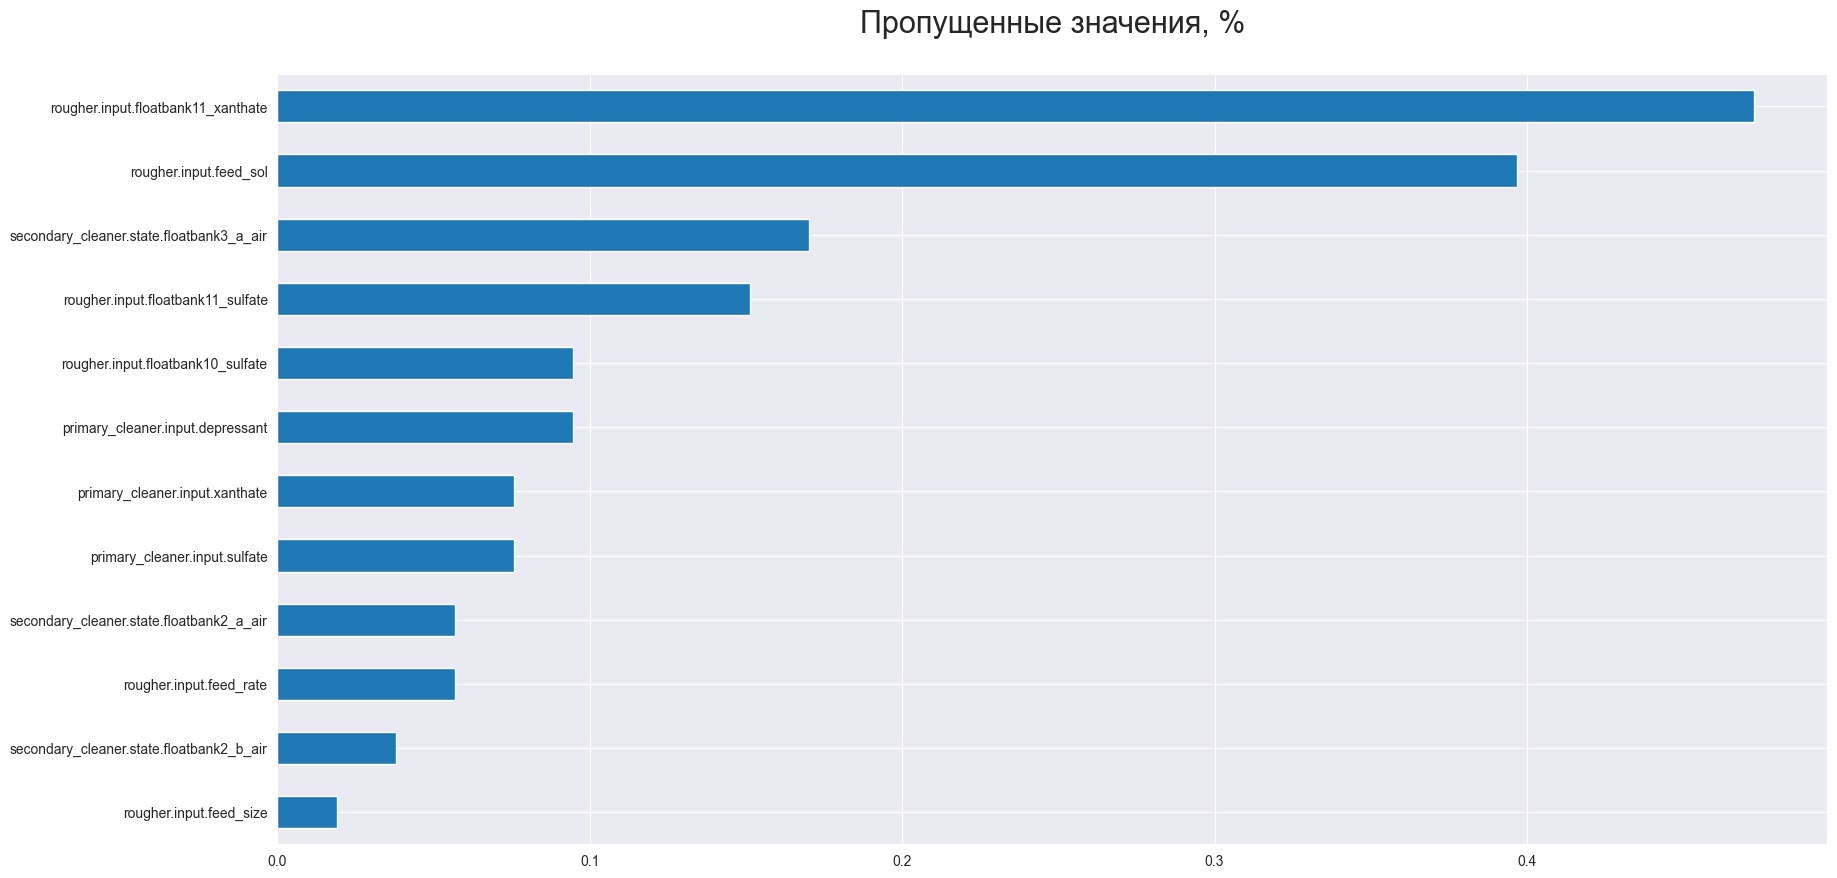

In [8]:
research_info(gold_test_data)

Можно заметить, что размеры обучающей и тестовой выборок сильно отличаются по количеству столбцов с данными. Проверим какие данные они собой представляют.

In [9]:
# Отсутствующие столбцы в test_df
missing_columns = list(set(gold_train_data.columns) - set(gold_test_data.columns))
print('В обучающей выборке на {} столбца больше, чем в тестовой'.format(len(missing_columns)))
print(gold_train_data[missing_columns].dtypes)

В обучающей выборке на 34 столбца больше, чем в тестовой
rougher.calculation.au_pb_ratio                       float64
rougher.output.concentrate_pb                         float64
rougher.output.tail_pb                                float64
primary_cleaner.output.tail_sol                       float64
secondary_cleaner.output.tail_pb                      float64
primary_cleaner.output.tail_ag                        float64
rougher.output.recovery                               float64
primary_cleaner.output.concentrate_pb                 float64
primary_cleaner.output.concentrate_ag                 float64
rougher.calculation.floatbank11_sulfate_to_au_feed    float64
final.output.concentrate_pb                           float64
rougher.output.tail_au                                float64
final.output.tail_ag                                  float64
final.output.concentrate_au                           float64
final.output.concentrate_ag                           float64
final.output.

In [10]:
step = collections.Counter()
type_step = collections.Counter()
data = collections.Counter()
list_columns = list(set(gold_train_data.columns) - set(gold_test_data.columns))
for i in list_columns:
    words = list(map(str, i.split(".")))
    step[words[0]] += 1
    type_step[words[1]] += 1
    data[words[2]] += 1

In [11]:
step, type_step, data

(Counter({'rougher': 13,
          'primary_cleaner': 8,
          'secondary_cleaner': 4,
          'final': 9}),
 Counter({'calculation': 4, 'output': 30}),
 Counter({'au_pb_ratio': 1,
          'concentrate_pb': 3,
          'tail_pb': 4,
          'tail_sol': 4,
          'tail_ag': 4,
          'recovery': 2,
          'concentrate_ag': 3,
          'floatbank11_sulfate_to_au_feed': 1,
          'tail_au': 4,
          'concentrate_au': 3,
          'concentrate_sol': 3,
          'sulfate_to_au_concentrate': 1,
          'floatbank10_sulfate_to_au_feed': 1}))

В тесте отсутствуют параметры, которые обозначают характеристики этапов обработки. Заметим, что из 34 пропущенных признака 30 относятся к параметрам продукта и только 4 к расчетным характеристикам
1. Признаки output - целевые признаки и поэтому отсутствуют в тестовой выборке.
2. Признаки rougher.calculation - это расчетные характеристики и отсутствуют они скорее всего из-за того, что они рассчитываются после завершения процесса.

Наблюдения:
- 9 пропущенных признаков этапа final, 8 primary_cleaner, 9 rougher, 4 secondary_cleaner относятся к параметрам продукта
- 4 пропущенных признака этапа rougher относятся к расчетным характеристикам
- На всех этапах отсутствует информация о хвостовых частях
- Во всех этапах, кроме повторной очистки отсутствует информация о доле металлов
- У финального этапа и этапа флотации отсутствуют признаки обогащения
- Так же отсутствуют данные о некоторых реагентах на этапе флотации

**Проверка правильности вычисленной эффективности обогащения.**
Напишем функцию для расчета Recovery по формуле
$Recovery = \frac{C*(F-T)}{F*(C-T)} * 100% $
где:

- C — доля золота в концентрате после флотации/очистки (rougher.output.concentrate_au)
- F — доля золота в сырье/концентрате до флотации/очистки (rougher.input.feed_au)
- T — доля золота в отвальных хвостах после флотации/очистки (rougher.output.tail_au)

In [12]:
def calculate_recovery(rougher_output, rougher_input, rougher_tail):
    recovery = (rougher_output * (rougher_input - rougher_tail)) / (
            rougher_input * (rougher_output - rougher_tail)) * 100
    return recovery

In [13]:
recovery = calculate_recovery(
    gold_train_data['rougher.output.concentrate_au'],
    gold_train_data['rougher.input.feed_au'],
    gold_train_data['rougher.output.tail_au'],
)

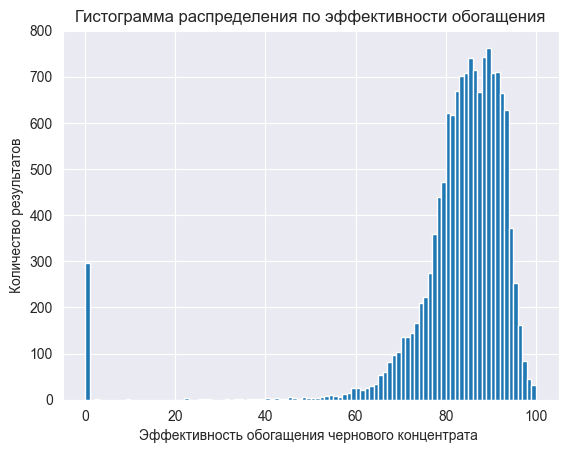

In [14]:
plt.hist(recovery, bins=100)
plt.xlabel("Эффективность обогащения чернового концентрата ")
plt.ylabel("Количество результатов")
plt.title("Гистограмма распределения по эффективности обогащения")
plt.show()

Вычислим MAE между проведенными расчётами и значением признака rougher.output.recovery

In [15]:
mae_recovery = MAE(gold_train_data['rougher.output.recovery'].dropna(), recovery.dropna())
print('MAE = {}'.format(mae_recovery))

MAE = 9.73512347450521e-15


Вывод: MAE (средняя абсолютная ошибка) между рассчитанной по формуле эффективностью обогащения и признаком из датасета очень мала, а значит значение эффективности в датасете верное.

Проведем обработку данных. Для этого необходимо сделать следующее:
- используем KNNImputer() для заполнения пропущенных значений с использованием подхода к-ближайших соседей, т.к. в описании данных указано, что соседние по времени параметры часто похожи;
- добавим целевые показатели в датасет gold_recovery_test из датасета gold_recovery_full, в качестве ключа использовав date;
- разделим данные на target и features.

In [16]:
gold_train_no_nan = gold_train_data.fillna(method='ffill')

In [17]:
gold_test_data = gold_test_data.dropna(subset=['date'], axis=0)
gold_test_data = gold_test_data.merge(gold_full_data.loc[:, ['date', TARGETS[0], TARGETS[1]]], on='date')

gold_test_data = gold_test_data.drop('date', axis=1)
gold_test_no_nan = gold_test_data.fillna(method='ffill')

Количество стобцов: 87
Количество строк: 14149
Дубликатов: 0


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
2102,2016-05-05 10:59:59,5.433970,10.850870,9.933775,44.719957,58.056171,7.882134,2.168839,12.753468,4.004951,...,14.017557,-499.800826,11.995458,-500.690591,11.012614,-501.040870,9.949721,-500.106360,19.969388,-501.126599
4131,2016-08-07 00:59:59,6.337412,10.954505,5.840162,34.848374,39.889951,8.413771,2.429566,4.576216,4.088879,...,19.987365,-399.242050,9.960474,-400.249495,9.108346,-401.596519,4.884565,-400.414931,22.977007,-502.385098
3386,2016-06-30 16:59:59,7.453246,5.428765,12.169679,44.935465,70.225824,9.883756,1.729325,7.650360,2.329601,...,16.978362,-499.065182,9.078607,-483.162047,16.979960,-480.527179,7.912707,-305.965321,25.007507,-460.132164
811,2016-02-21 05:00:00,7.072607,11.022229,11.263429,39.822846,69.665281,13.416641,2.889180,10.036865,3.692713,...,12.026272,-400.881040,10.014713,-400.193674,10.078281,-401.353622,7.963552,-400.019744,21.986586,-400.558066
1129,2016-03-05 21:00:00,7.967769,11.466836,8.287695,34.851909,62.632376,9.710112,0.696100,17.435122,2.070735,...,14.057871,-401.505494,14.039243,-400.664043,12.029364,-402.244364,9.984162,-399.921695,23.996151,-402.936955


пропусков не осталось :) 


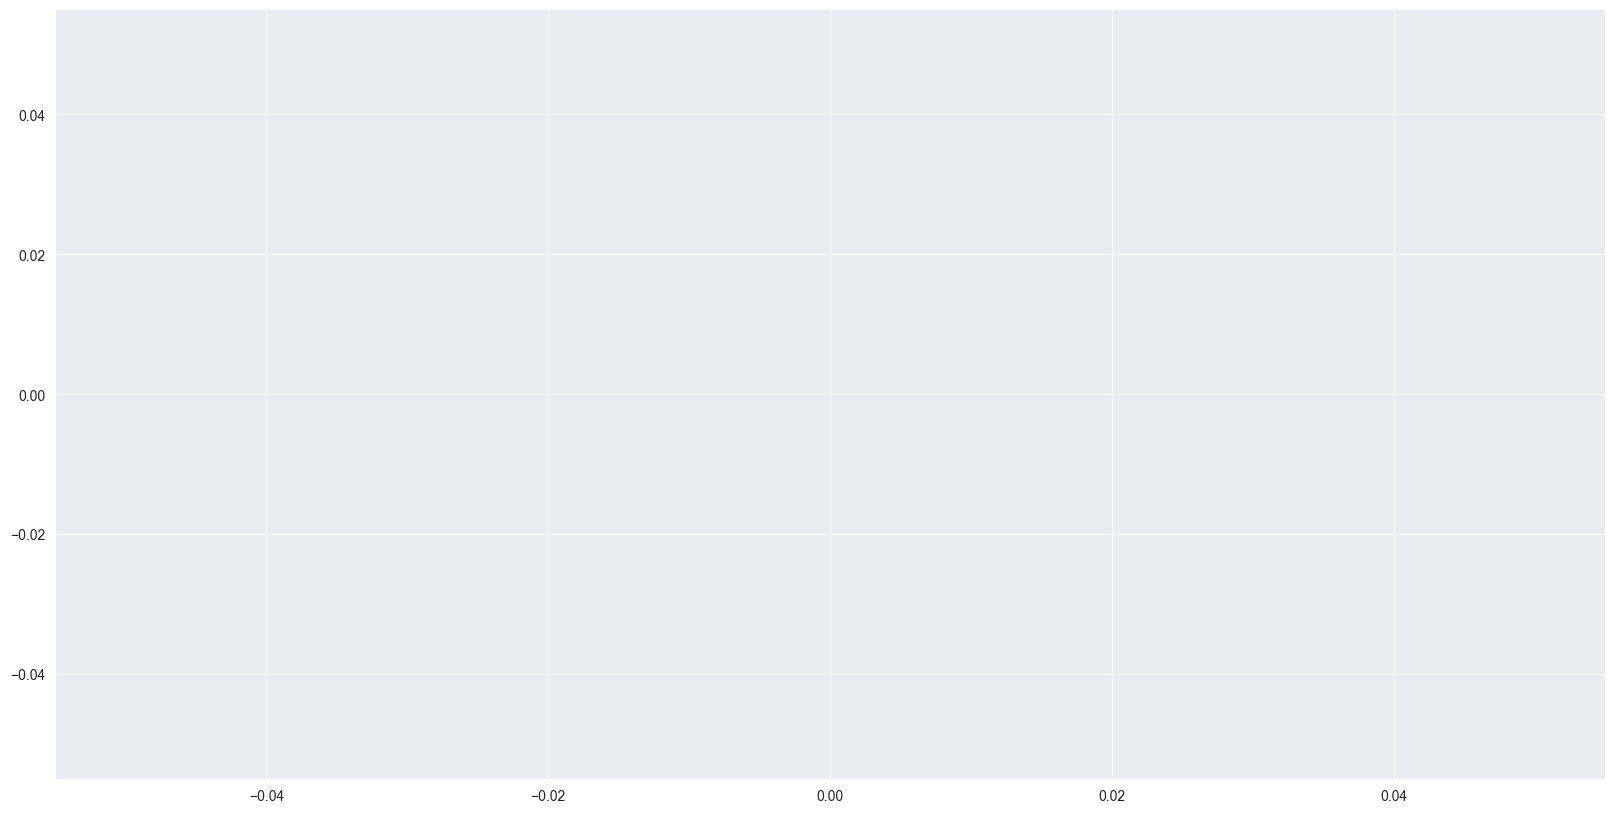

In [18]:
research_info(gold_train_no_nan)

Количество стобцов: 54
Количество строк: 5290
Дубликатов: 0


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
1599,234.487332,9.013551,7.17,1.298322,1599.875543,-499.801006,1603.250440,-499.566267,1598.231699,-498.795931,...,13.953374,-501.165610,15.551943,-499.254097,13.972293,-499.812056,21.988364,-498.019054,83.543104,65.888632
1787,187.779153,6.038735,7.40,1.909059,1591.039086,-499.896305,1597.915806,-499.614620,1601.378645,-499.221746,...,16.032337,-499.394623,17.239080,-500.271999,11.993991,-499.957559,21.968355,-499.408364,86.648231,90.771961
2882,150.732950,8.476430,6.75,1.592252,1400.610767,-500.221124,1400.436342,-499.152818,1400.328109,-498.973104,...,9.073864,-400.117407,8.968393,-500.230669,7.065703,-500.244151,9.997739,-500.029580,87.958414,67.506466
4621,201.993227,10.005968,6.74,2.395294,1583.044558,-502.259441,1581.058567,-497.214526,1578.299265,-501.299483,...,14.955031,-510.300043,10.985700,-494.754122,9.036271,-500.163227,23.024767,-498.075108,93.990620,60.123931
2075,201.012828,8.996749,7.59,0.968566,1501.466029,-500.070780,1503.553732,-499.666899,1503.803314,-499.463047,...,15.969226,-501.080786,17.193788,-500.644443,12.010404,-499.204754,21.001403,-500.185769,89.077200,73.833996


пропусков не осталось :) 


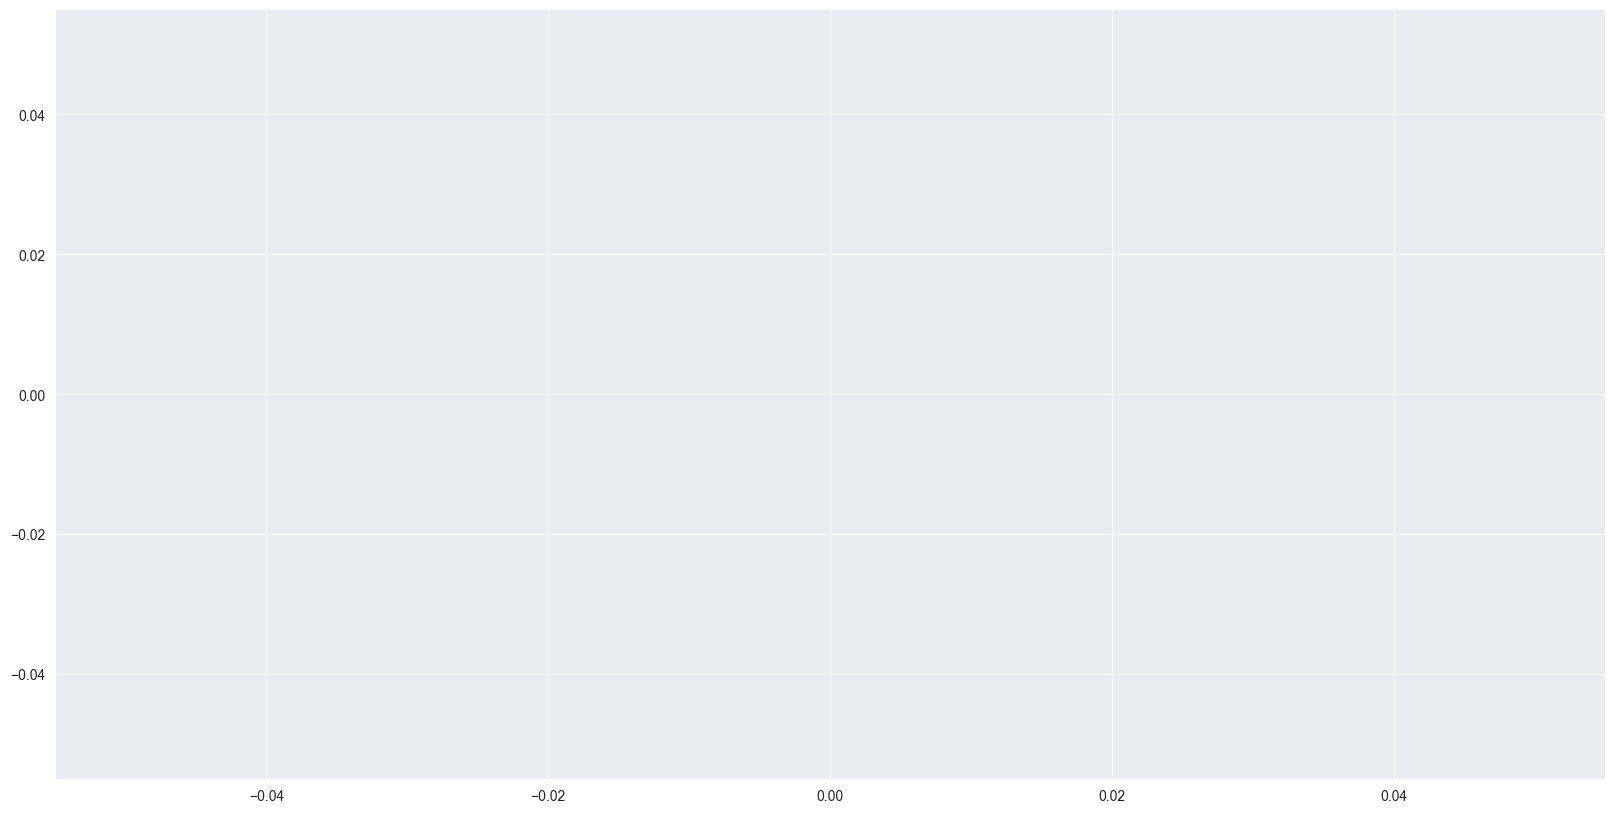

In [19]:
research_info(gold_test_no_nan)

**Итог первичного анализа:**
- проверено, что эффективность обогащения рассчитана правильно;
- данные проверены на отсутствие дубликатов;
- данные проверены на отсутствие пропусков;
- имеющиеся пропуски были устранены;
- тестовый датасет был дополнен целевыми показателями из `gold_full_data`.

## Шаг 2. Анализ данных <a class="anchor" id="section2"></a>

**Анализ изменения концентрация металлов (Au, Ag, Pb) на различных этапах очистки**
Посмотрим, как изменяется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

- Au - золото;
- Ag - серебро;
- Pb - свинец.

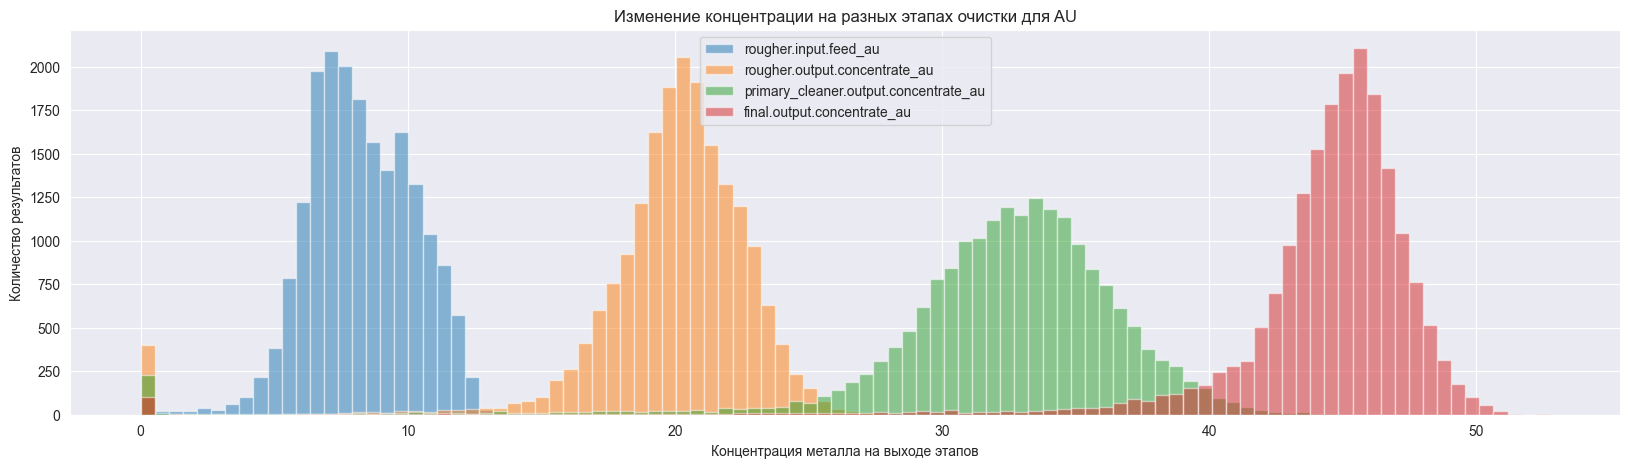

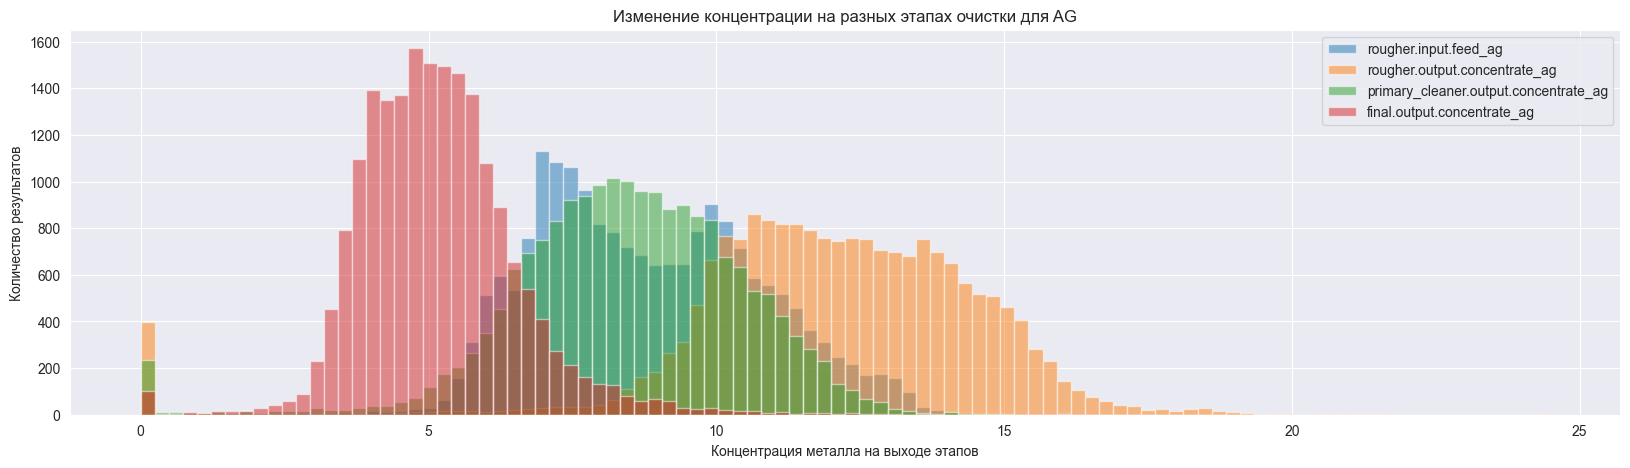

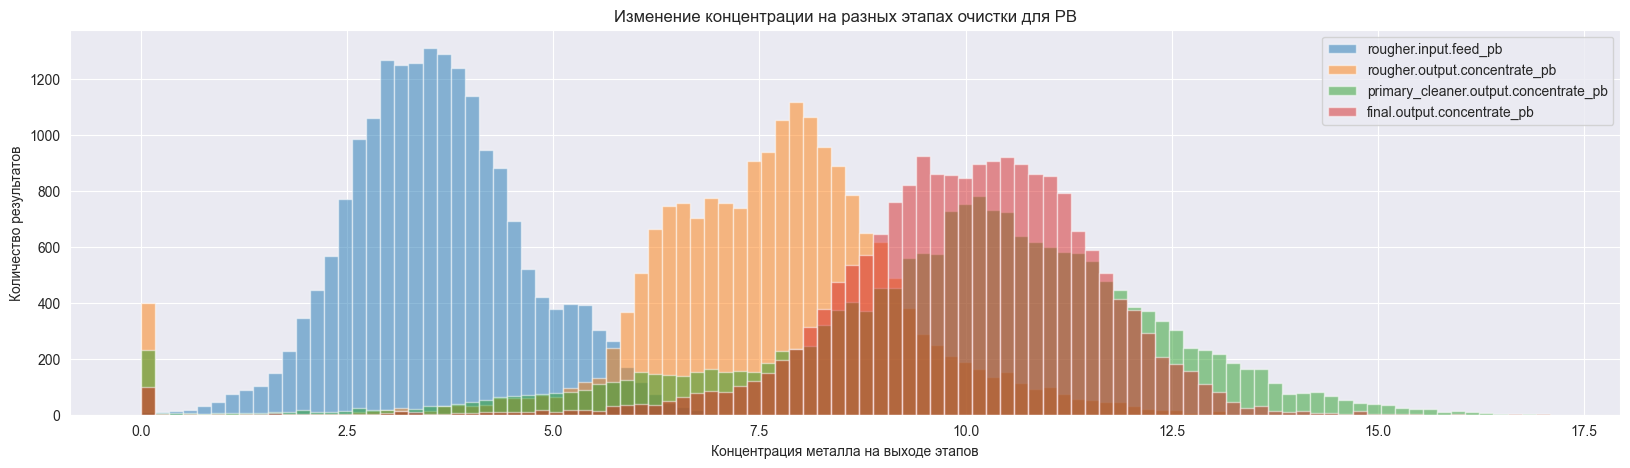

In [20]:
for metal in METALS:
    metrics = ['{}_{}'.format(x, metal) for x in CONCENTRATE_METRICS]
    gold_full_data[metrics].plot(
        kind='hist',
        bins=100,
        grid=True,
        legend=True,
        figsize=(20, 5),
        alpha=0.5,
    ).set(title='Изменение концентрации на разных этапах очистки для {}'.format(metal.upper()),
          xlabel='Концентрация металла на выходе этапов', ylabel='Количество результатов')
    plt.show()

Что можно понять из графиков:
- концентрация золота повышается с каждым этапом. Цель флотации и очисток увеличить концентрацию золота;
- концентрация серебра понижается с каждым шагом очистки. Так как основным благородным металлом является золото, то остальные металлы и соединения должны быть отфильтрованы;
- концентрация свинца повышается с этапа rougher до primary_cleaner. И потом усредняется. Это связано с химическим процесами очищения золота. При использовании азотнокислого выщелачивания в концентрате образуется много сульфата свинца. Повышение концентрации свинца в целом происходит не только из-за этого процесса, но из-за очищения других составляющих из золотоносной руды.

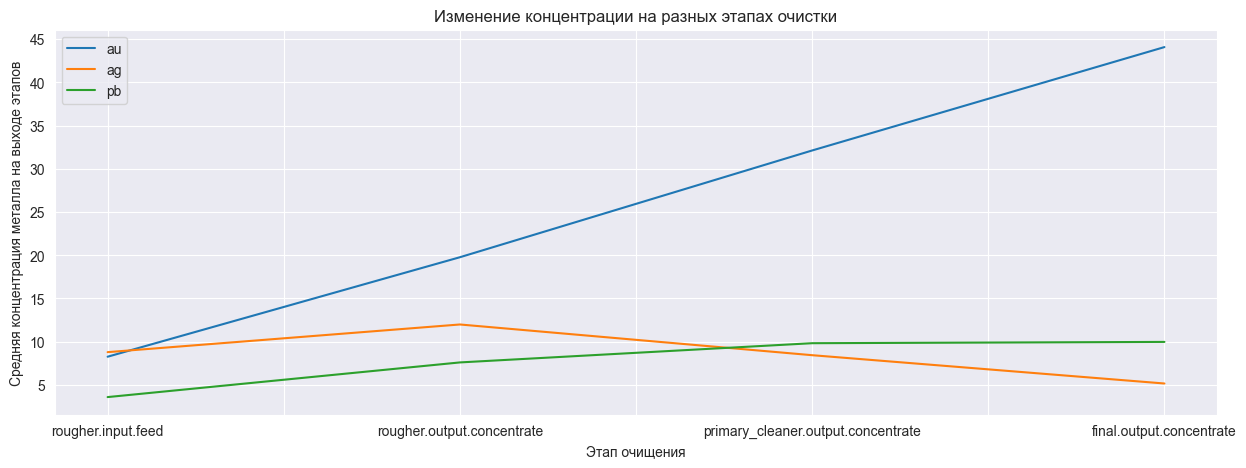

,rougher.input.feed,rougher.output.concentrate,primary_cleaner.output.concentrate,final.output.concentrate
au,8.266097,19.772,32.1194,44.076513
ag,8.794927,11.994759,8.442408,5.16847
pb,3.598085,7.606272,9.82953,9.978895


In [21]:
metals_concentrate = pd.DataFrame(columns=CONCENTRATE_METRICS)

for metal in METALS:
    metal = metal.lower()

    for metric in CONCENTRATE_METRICS:
        metals_concentrate.loc[metal, metric] = gold_full_data['{}_{}'.format(metric, metal)].mean()

for metal in METALS:
    metals_concentrate.loc[metal].plot(
        grid=True,
        legend=True,
        figsize=(15, 5)
    ).set(title='Изменение концентрации на разных этапах очистки', xlabel='Этап очищения',
          ylabel='Средняя концентрация металла на выходе этапов')
plt.show()

display(metals_concentrate)

Что можно понять из графиков:
- концентрация Au (золота) растет на протяжеии всех этапов и в конце становится примерно в 5 раза больше, чем в начале;
- концентрация Ag (серебра) падает начиная с этапа флотации;
- концентрация Pb (свинца) медленно растет на протяжении всех этапов очистки.

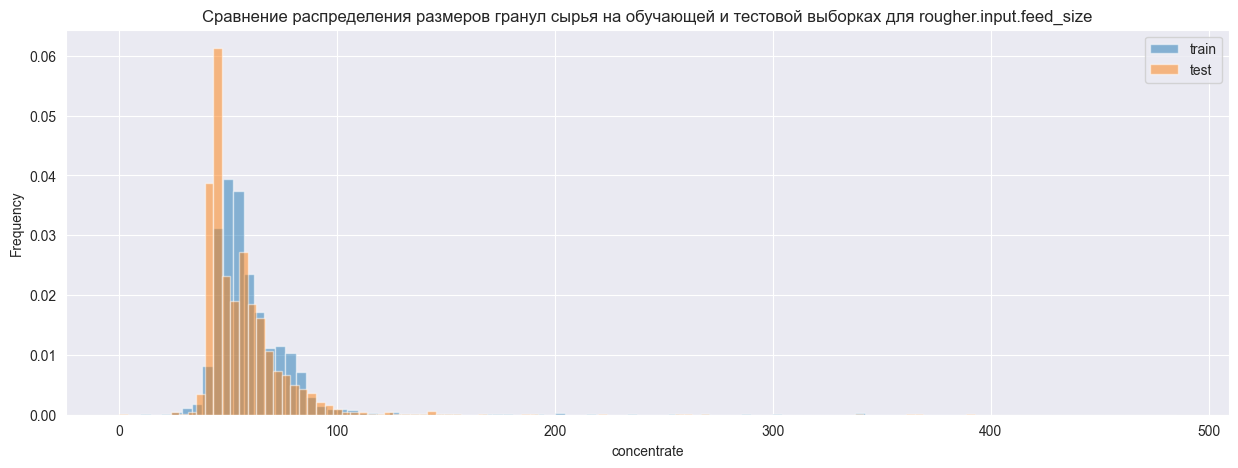

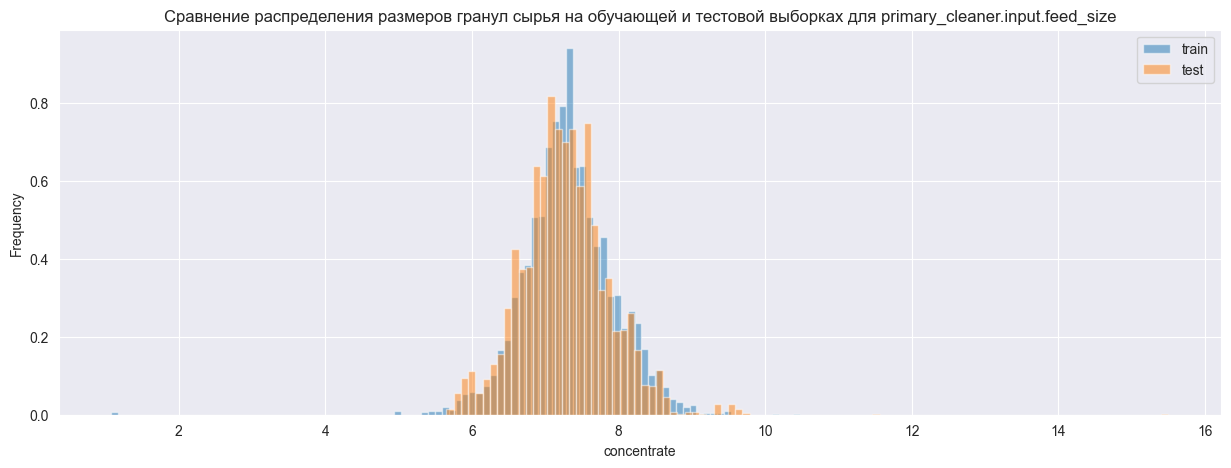

In [22]:
for metric in ('rougher.input.feed_size', 'primary_cleaner.input.feed_size'):
    for label, df in (('train', gold_train_no_nan), ('test', gold_test_no_nan)):
        df[metric].plot(
            kind='hist',
            bins=100,
            grid=True,
            legend=True,
            figsize=(15, 5),
            alpha=0.5,
            label=label,
            density=True
        ).set(title='Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках для {}'.format(
            metric), xlabel='concentrate')

    plt.show()

Из графиков видно, что распределение размеров гранул сырья на обучающей и тестовой выборках совпадает, а значит оценка модели будет правильной.

**Расчет суммарной концентрации**

In [23]:
def summary_of_concentarution(row):
    list_of_steps = ["rougher", "primary_cleaner", "final"]
    input_feed_au = row["rougher.input.feed_au"]
    input_feed_ag = row["rougher.input.feed_ag"]
    input_feed_pb = row["rougher.input.feed_pb"]
    input_feed_sol = row["rougher.input.feed_sol"]
    out_rougher = []
    out_primary_cleaner = []
    out_final = []
    list_of_arrays = [out_rougher, out_primary_cleaner, out_final]
    for step, array in zip(list_of_steps, list_of_arrays):
        array.append(row[step + ".output.concentrate_au"])
        array.append(row[step + ".output.concentrate_ag"])
        array.append(row[step + ".output.concentrate_pb"])
        array.append(row[step + ".output.concentrate_sol"])
    sum_before_steps = input_feed_ag + input_feed_au + input_feed_pb + input_feed_sol
    sum_rougher = sum(out_rougher)
    sum_primary = sum(out_primary_cleaner)
    sum_final = sum(out_final)
    return pd.Series([sum_before_steps, sum_rougher, sum_primary, sum_final])

In [24]:
sum_values = gold_train_no_nan.apply(summary_of_concentarution, axis=1)
sum_values.columns = ['before_rougher', 'rougher', 'primary_cleaner', 'final']

In [25]:
sum_values.sample(n=5)

,before_rougher,rougher,primary_cleaner,final
2121,54.029801,75.856267,56.870607,70.623006
11722,56.679570,41.478687,60.685068,71.202314
8966,43.694529,77.132906,62.796635,68.863809
6793,57.952676,63.938190,52.898951,70.725762
2737,44.251927,70.013247,50.483763,65.001349


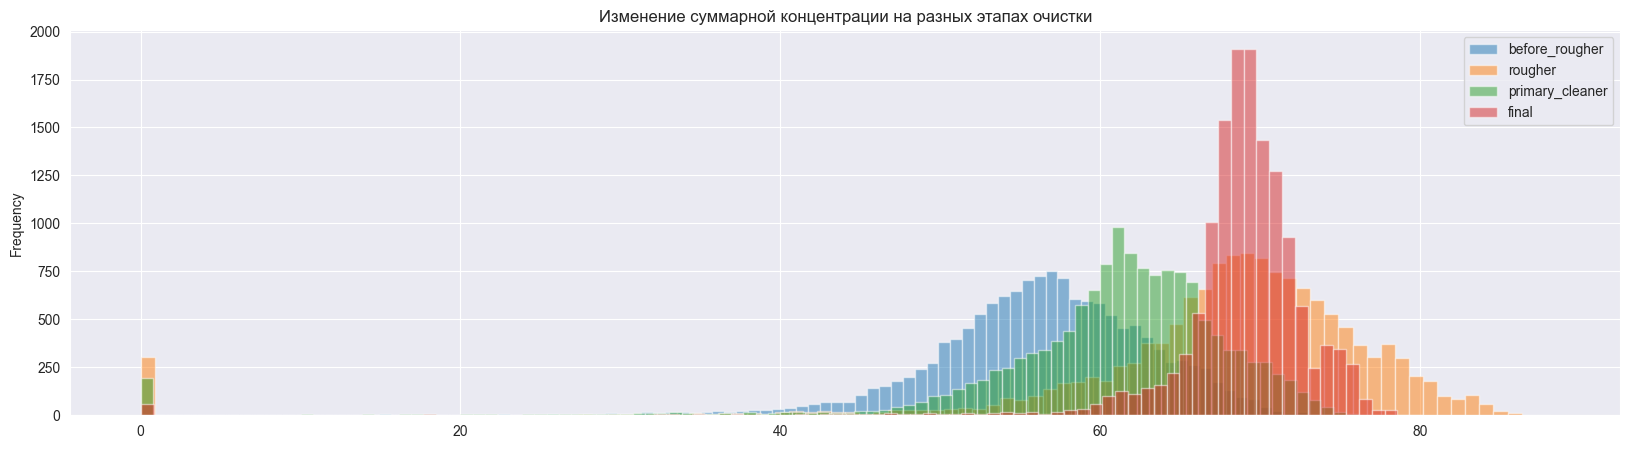

In [26]:
for columns in ['before_rougher', 'rougher', 'primary_cleaner', 'final']:
    sum_values[columns].plot(
        kind='hist',
        bins=100,
        grid=True,
        legend=True,
        figsize=(20, 5),
        alpha=0.5,
    ).set(title='Изменение суммарной концентрации на разных этапах очистки')
plt.show()

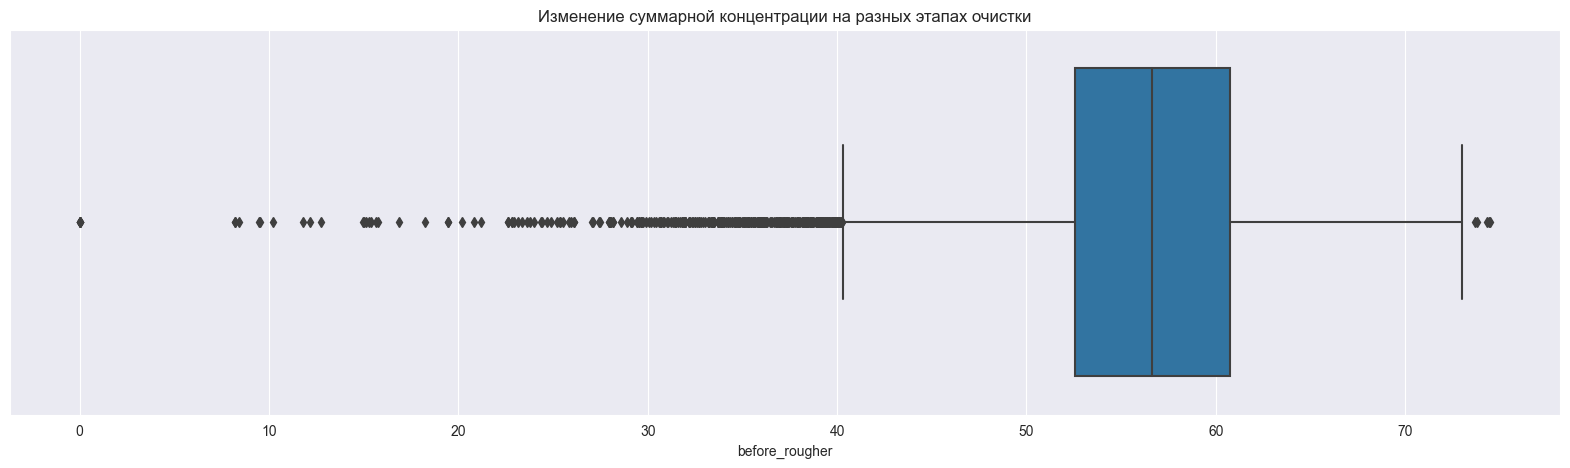

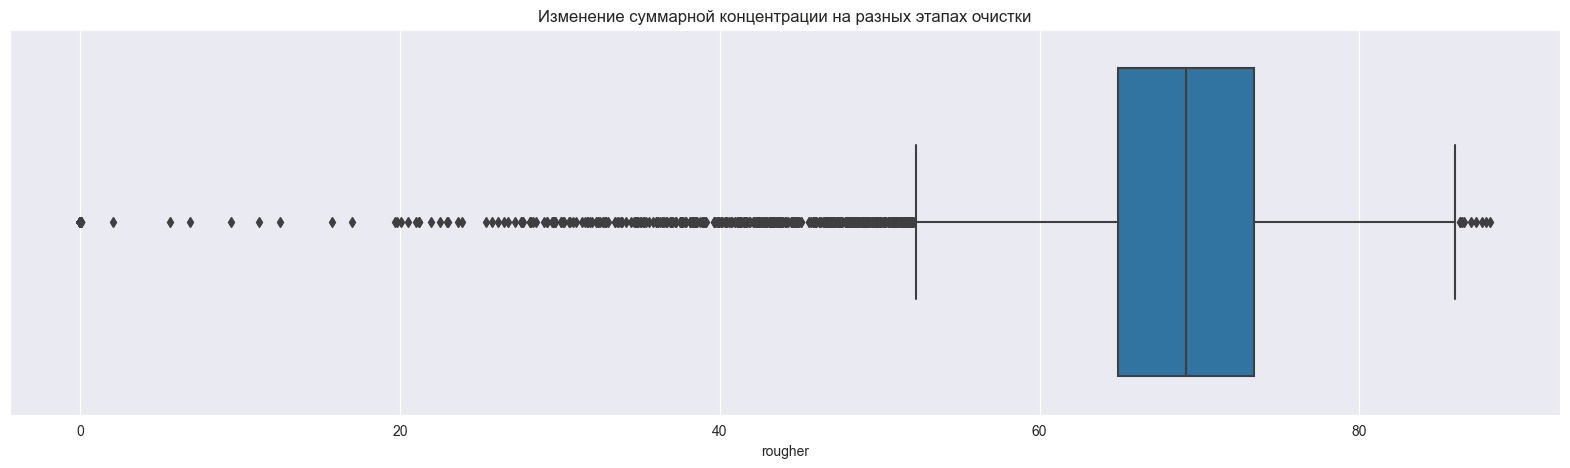

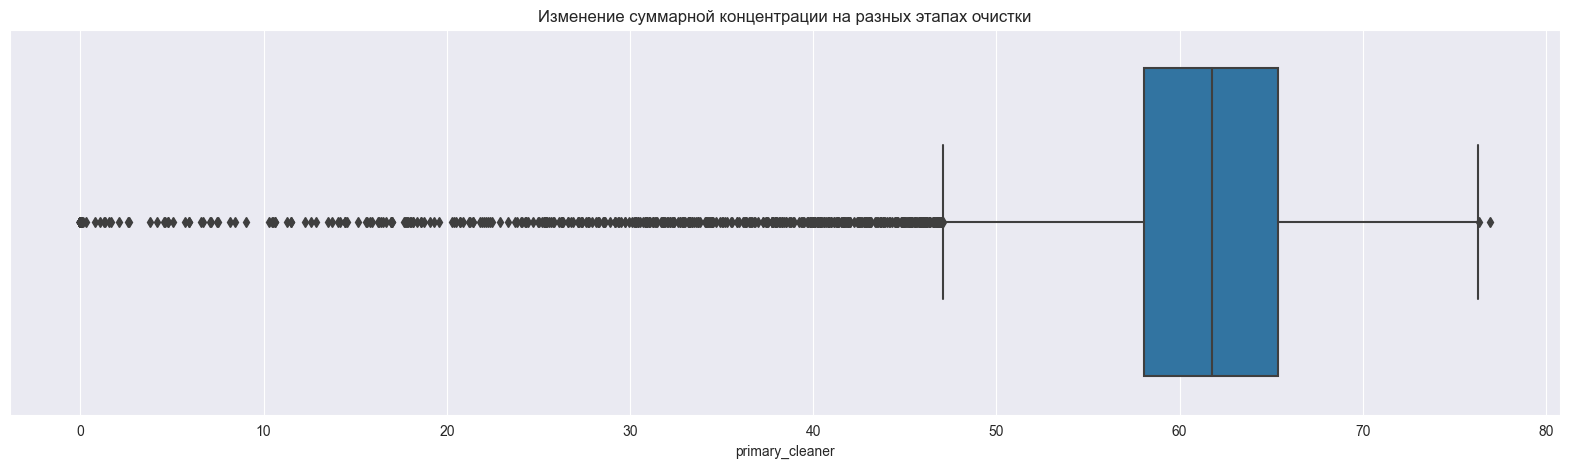

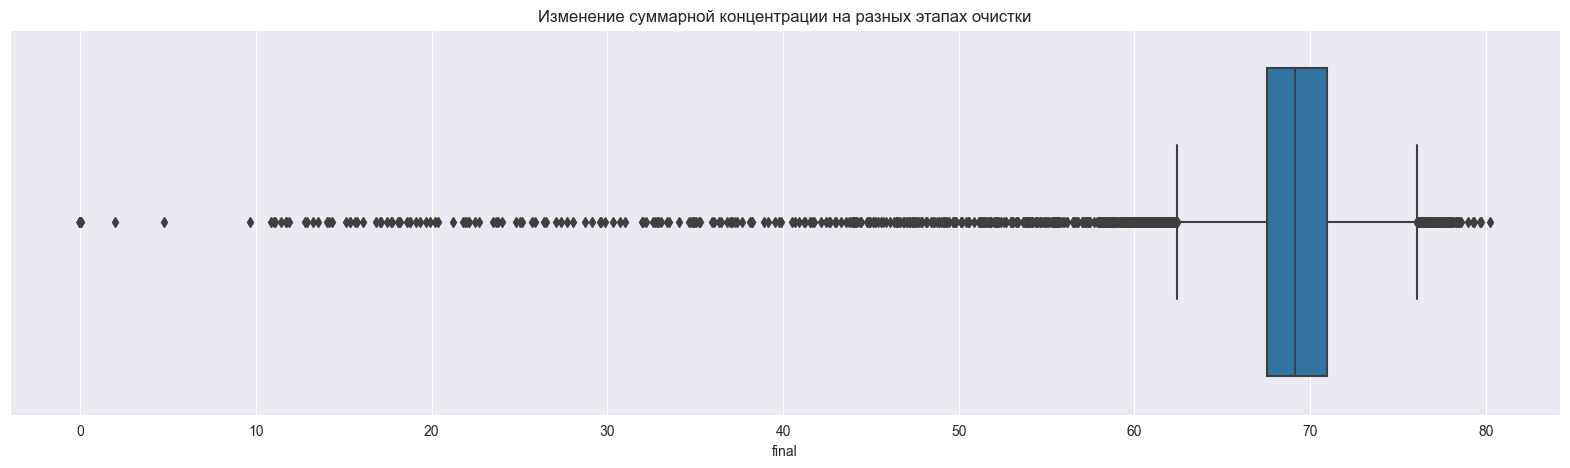

In [27]:
for columns in ['before_rougher', 'rougher', 'primary_cleaner', 'final']:
    plt.figure(figsize=(20, 5))
    sns.boxplot(data=sum_values, x=columns).set(title='Изменение суммарной концентрации на разных этапах очистки',
                                                label=columns)
    plt.show()

Можно заметить, что на каждом этапе есть довольно много выбросов, значит нужно избавиться от этих аномалий.

In [28]:
print(sum_values.shape)
print(gold_train_no_nan.shape)

(14149, 4)
(14149, 87)


In [29]:
def remove_tails(data):
    for columns in ['before_rougher', 'rougher', 'primary_cleaner', 'final']:
        del_index = []
        q25 = np.array(sum_values[columns].quantile(0.25))
        q75 = np.array(sum_values[columns].quantile(0.75))
        min_part = q25 - 1.5 * (q75 - q25)
        for index_value, value in zip(sum_values[columns].index, sum_values[columns]):
            if value <= min_part:
                del_index.append(index_value)
    return del_index

In [30]:
len_before = len(gold_train_no_nan)
indexes = remove_tails(gold_train_no_nan)
sum_indexes = len(indexes)
gold_train_no_nan.drop(index = indexes, axis=0, inplace=True)
len_after = len(gold_train_no_nan)
print('Удалено {} строк, доля оставшихся данных от исходных {:.2%}'.format(sum_indexes, len_after / len_before))

Удалено 813 строк, доля оставшихся данных от исходных 94.25%


Удалим лишние признаки из train, т.е те, которых нет в test

In [31]:
# Отсутствующие столбцы в test_df
missing_columns_rougher = list(set(gold_train_no_nan.columns) - set(gold_test_no_nan.columns))
missing_columns_final = list(set(gold_train_no_nan.columns) - set(gold_test_no_nan.columns))
print('В обучающей выборке на {} столбца больше, чем в тестовой'.format(len(missing_columns_rougher)))
# print(missing_columns)
gold_train_no_nan = gold_train_no_nan.drop(missing_columns_rougher, axis='columns')
# gold_train_features_final = gold_train_no_nan.drop(missing_columns_final, axis='columns')
if len(list(set(gold_train_no_nan.columns) - set(gold_test_no_nan.columns))) == 0:
    print('Отлично, теперь в обучающей и тестовой выборке одни и те же признаки :)')
else:
    print('Надо что-то исправить')

В обучающей выборке на 33 столбца больше, чем в тестовой
Отлично, теперь в обучающей и тестовой выборке одни и те же признаки :)


Подготовленные данные обучающей таблицы разделим на признаки для предсказания rougher.output.recovery и final.output.recovery.

In [32]:
gold_train_features_rougher = gold_train_no_nan.drop(TARGETS, axis='columns')
gold_train_target_rougher = gold_train_no_nan[TARGETS[0]]
gold_train_features_final = gold_train_no_nan.drop(TARGETS, axis='columns')
gold_train_target_final = gold_train_no_nan[TARGETS[1]]

gold_test_features_rougher = gold_test_no_nan.drop(TARGETS, axis='columns')
gold_test_target_rougher = gold_test_no_nan[TARGETS[0]]
gold_test_features_final = gold_test_no_nan.drop(TARGETS, axis='columns')
gold_test_target_final = gold_test_no_nan[TARGETS[1]]

**Итог:**
В результате анализа были изучены:
- концетрации основных веществ на разных этапах очистки;
- размер гранул тестовой и обучающей выборки;
- суммарная концентрация веществ;
- аномалии были удалены;
- обучающая и тестовая выборки имеют одинаковый набор столбцов;
- данные разделены на признаки и целевые значения.

Данные готовы к обучению.

## Шаг 3. Построение модели и её оценка <a class="anchor" id="section3"></a>

Функция для расчета sMAPE
$sMAPE = \frac{1}{N}\sum_{i=1}^{N}\frac{|{y}_i - {\hat{{y}_i}}|}{(|{y}_i + {\hat{{y}_i}}|)/2}*100%$

где:

${y}_i$ — значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество
$\hat{{y}_i}$ — значение предсказания для объекта с порядковым номером i, например, в тестовой выборке
N — количество объектов в выборке
$\sum_{i=1}^{N}$ — суммирование по всем объектам выборки (i меняется от 1 до N).

А итоговая sMAPE считается как sMAPE = 25%*sMAPE(rougher)+75%*sMAPE(final)

In [41]:
def sMAPE(y_true, y_pred):
    return abs((1 / len(y_pred)) * np.sum(np.abs(y_true - y_pred) / ((np.abs(y_true + y_pred)) / 2)) * 100)

Создадим scorer для того, чтобы применить его при кросс-валидации

In [42]:
smape_scorer = make_scorer(sMAPE, greater_is_better=False)

Теперь обучим модели и посмотрим, какая даст лучшее значение sMAPE

**Линейная регрессия**

In [43]:
lr_model = LinearRegression()
lr_model_rougher = lr_model.fit(gold_train_features_rougher, gold_train_target_rougher)
lr_model_final = lr_model.fit(gold_train_features_final, gold_train_target_final)
smape_rougher = cross_val_score(lr_model, gold_train_features_rougher, gold_train_target_rougher, cv=5,
                                scoring=smape_scorer).mean()
smape_final = cross_val_score(lr_model, gold_train_features_final, gold_train_target_final, cv=5,
                              scoring=smape_scorer).mean()
print(
    'Лучшее значение sMAPE для линейной регрессии по rougher.output.recovery: {}, по final.output.recovery: {}'.format(
        -smape_rougher, -smape_final))


  0%|          | 0/100 [00:00<?, ?it/s]

Лучшее значение sMAPE для линейной регрессии по rougher.output.recovery: 12.064911036120694, по final.output.recovery: 10.228056073320975


**Дерево решений**

In [44]:
dtr_model = DecisionTreeRegressor(random_state=RANDOM_VAL)
dtc_param_grid = {'max_depth': np.arange(1, 10)}
dtr_search = GridSearchCV(dtr_model,  # модель
                          param_grid=dtc_param_grid,  # гиперпараметры
                          cv=5,  #
                          scoring=smape_scorer,  # метрика проверки
                          )

dtr_search_rougher = dtr_search.fit(gold_train_features_rougher, gold_train_target_rougher)
dtr_search_final = dtr_search.fit(gold_train_features_final, gold_train_target_final)
print(
    'Лучшее значение sMAPE для дерева решений по rougher.output.recovery: {} при значениях гиперпараметров: {}'.format(
        -dtr_search_rougher.best_score_, dtr_search_rougher.best_params_))
print('Лучшее значение sMAPE для дерева решений по final.output.recovery: {} при значениях гиперпараметров: {}'.format(
    -dtr_search_final.best_score_, dtr_search_final.best_params_))

  0%|          | 0/100 [00:00<?, ?it/s]

Лучшее значение sMAPE для дерева решений по rougher.output.recovery: 8.927495649683276 при значениях гиперпараметров: {'max_depth': 3}
Лучшее значение sMAPE для дерева решений по final.output.recovery: 8.927495649683276 при значениях гиперпараметров: {'max_depth': 3}


**Случайный лес**

In [45]:
rfr_model = RandomForestRegressor(random_state=RANDOM_VAL)
rfr_param_grid = {'n_estimators': np.arange(10, 31, 10),
                  'max_depth': np.arange(1, 20)}
rfr_search = GridSearchCV(rfr_model,
                          rfr_param_grid,
                          cv=5,
                          scoring=smape_scorer)
rfr_search_rougher = rfr_search.fit(gold_train_features_rougher, gold_train_target_rougher)
rfr_search_final = rfr_search.fit(gold_train_features_final, gold_train_target_final)
print(
    'Лучшее значение sMAPE для случайного леса по rougher.output.recovery: {} при значениях гиперпараметров: {}'.format(
        -rfr_search_rougher.best_score_, rfr_search_rougher.best_params_))
print('Лучшее значение sMAPE для случайного леса по final.output.recovery: {} при значениях гиперпараметров: {}'.format(
    -rfr_search_final.best_score_, rfr_search_final.best_params_))

  0%|          | 0/100 [00:00<?, ?it/s]

Лучшее значение sMAPE для случайного леса по rougher.output.recovery: 8.763232574875659 при значениях гиперпараметров: {'max_depth': 3, 'n_estimators': 20}
Лучшее значение sMAPE для случайного леса по final.output.recovery: 8.763232574875659 при значениях гиперпараметров: {'max_depth': 3, 'n_estimators': 20}
CPU times: total: 48min 22s
Wall time: 48min 37s


Выяснили, что лучшая модель - случайный лес. Проверим ее качество на тестовой выборке.

In [46]:
predictions_test_rougher = rfr_search_rougher.predict(gold_test_features_rougher)
predictions_test_final = rfr_search_final.predict(gold_test_features_final)
print('sMAPE для тестовых данных по rougher.output.recovery: {}'.format(sMAPE(gold_test_target_rougher, predictions_test_rougher)))
print('sMAPE для тестовых данных по final.output.recovery: {}'.format(sMAPE(gold_test_target_final, predictions_test_rougher)))
print('Итоговое sMAPE для тестовых данных {}'.format(0.25 * sMAPE(gold_test_target_rougher, predictions_test_rougher) + 0.75 * sMAPE(gold_test_target_final, predictions_test_rougher)))


sMAPE для тестовых данных по rougher.output.recovery: 27.32890972730391
sMAPE для тестовых данных по final.output.recovery: 9.522163625031418
Итоговое sMAPE для тестовых данных 13.97385015059954


In [47]:
dr_model = DummyRegressor(strategy='mean')
dr_search_rougher = dr_model.fit(gold_train_features_rougher, gold_train_target_rougher)
dr_search_final = dr_model.fit(gold_train_features_final, gold_train_target_final)
dr_predictions_test_rougher = dr_search_rougher.predict(gold_test_features_rougher)
dr_predictions_test_final = dr_search_final.predict(gold_test_features_final)
print('sMAPE для тестовых данных по rougher.output.recovery: {}'.format(sMAPE(gold_test_target_rougher, dr_predictions_test_rougher)))
print('sMAPE для тестовых данных по final.output.recovery: {}'.format(sMAPE(gold_test_target_final, dr_predictions_test_rougher)))
print('Итоговое sMAPE для тестовых данных {}'.format(0.25 * sMAPE(gold_test_target_rougher, dr_predictions_test_rougher) + 0.75 * sMAPE(gold_test_target_final, dr_predictions_test_rougher)))

sMAPE для тестовых данных по rougher.output.recovery: 28.87540980574075
sMAPE для тестовых данных по final.output.recovery: 9.933008466684962
Итоговое sMAPE для тестовых данных 14.668608801448908


**Итог:**
Была написана функция для вычисления sMAPE. Каждая модель была изучена на качество с помощью методов кросс-валидации и поиска гиперпараметров GridSearchCV.

Была отобрана лучшая модель - RandomForestRegressor. Ее значение sMAPE самое низкое.
Минимальное значение sMape на тестовой выборке у случайного леса с параметрами {'max_depth': 4, 'n_estimators': 10}. Этот результат лучше среднего, модель вменяема.

## Шаг 4. Общий вывод <a class="anchor" id="section4"></a>

В ходе проделанной работы было выполнено:
1. В рамках подготовки данных:
- проверена формула вычисления эффективности обогащения;
- проанализированы признаки, недоступные в тестовой выборке;
- проведена предобработка данных.
2. В рамках анализа данных:
- исследовано изменение концентрации элементов на каждом этапе;
- проанализированы распределения размеров гранул на обучающей и тестовой выборках;
- исследованы суммарные концентрации;
- проанализированы и обработаны аномальные значения.
3. Построена модель прогнозирования. Написана функция для вычисления итогового sMAPE. Обучено и проверено несколько моделей. Выбрана лучшая модель, её качество проверено на тестовой выборке и прошло проверку DummyRegressor.